## K2-24 Fitting & MCMC

Using the K2-24 (EPIC-203771098) dataset, we demonstrate how to use the radvel API to:

- perform a max-likelihood fit
- do an MCMC exploration of the posterior space
- plot the results


### Circular Orbits
Perform some preliminary imports:

In [1]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
from radvel.plot import orbit_plots, mcmc_plots

matplotlib.rcParams['font.size'] = 14

/Users/bfulton/anaconda3/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)
numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


Define a function that we will use to initialize the ``radvel.Parameters`` and ``radvel.RVModel`` objects

In [2]:
def initialize_model():
    time_base = 2420
    params = radvel.Parameters(2,basis='per tc secosw sesinw logk') # number of planets = 2
    params['per1'] = radvel.Parameter(value=20.885258)
    params['tc1'] = radvel.Parameter(value=2072.79438)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1.1)
    params['per2'] = radvel.Parameter(value=42.363011)
    params['tc2'] = radvel.Parameter(value=2082.62516)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1.1)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02)
    mod.params['curv'] = radvel.Parameter(value=0.01)
    return mod


Define a simple plotting function to display the data, model, and residuals

In [3]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    fig.set_tight_layout(True)
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Load up the K2-24 data. In this example the RV data and parameter starting guesses are stored in an csv file

In [4]:
path = os.path.join(radvel.DATADIR,'epic203771098.csv')
rv = pd.read_csv(path)

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = np.linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

Fit the K2-24 RV data assuming:

1. circular orbits
2. fixed period, time of transit

Set initial guesses for the parameters. Setting vary=False and linear=True on the gamma parameters will cause them to be solved for analytically following the technique described [here](http://cadence.caltech.edu/~bfulton/share/Marginalizing_the_likelihood.pdf) (Thanks Tim Brandt!). If you use this you will need to calculate the uncertainties on gammas manually following that derivation.

In [5]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = radvel.Parameter(value=0.1, vary=False, linear=True)
like.params['jit'] = radvel.Parameter(value=1.0)

Choose which parameters to vary or fix. By default, all `radvel.Parameter` objects will vary, so you only have to worry about setting the ones you want to hold fixed.

In [6]:
like.params['secosw1'].vary = False
like.params['sesinw1'].vary = False
like.params['secosw2'].vary = False
like.params['sesinw2'].vary = False
like.params['per1'].vary = False
like.params['per2'].vary = False
like.params['tc1'].vary = False
like.params['tc2'].vary = False
print(like)

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma                           0.1      False
jit                               1       True



Plot the initial model

<Figure size 432x288 with 0 Axes>

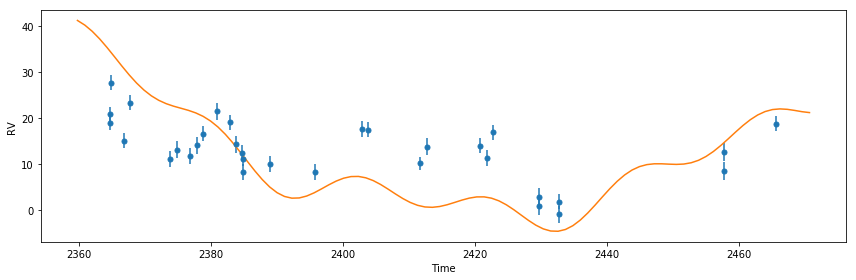

In [7]:
pl.figure()
plot_results(like)

Well that solution doesn't look very good. Now lets try to optimize the parameters set to vary by maximizing the likelihood.

Initialize a ``radvel.Posterior`` object and add some priors

In [8]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian( 'jit', np.log(3), 0.5)]
post.priors += [radvel.prior.Gaussian( 'logk2', np.log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'logk1', np.log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]

Maximize the likelihood and print the updated posterior object

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                       1.57864       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                       1.05897       True
dvdt                      0.0427633       True
curv                      0.0102147       True
gamma                      -13.0051      False
jit                         4.23199       True

Priors
------
Gaussian prior on jit, mu=1.0986122886681098, sigma=0.5
Gaussian prior on logk2, mu=1.6094379124341003, sigma=10
Gaussian prior on logk1, mu=1.6094379124341003, sigma=10
Gaussian prior on gamma, mu=0, sigma=10



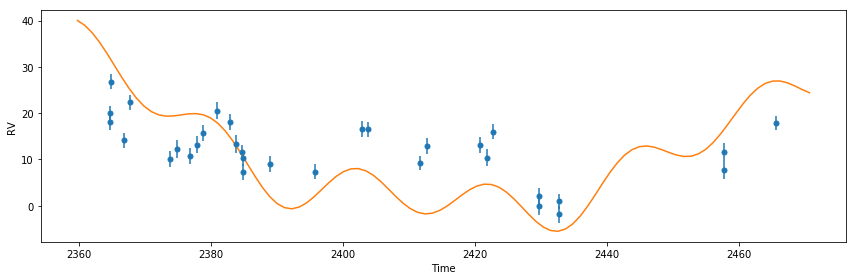

In [9]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

That looks much better!

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties.
In this example we will run 400 steps for the sake of speed but in practice you should let it run at least 10000 steps and ~50 walkers. If the chains converge before they reach the maximum number of allowed steps it will automatically stop.

In [10]:
df = radvel.mcmc(post,nwalkers=20,nrun=400)

64000/64000 (100.0%) steps complete; Running 23340.77 steps/s; Mean acceptance rate = 53.7%; Min Tz = 606.8; Max G-R = 1.050      

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


Now lets make a corner plot to display the posterior distributions.

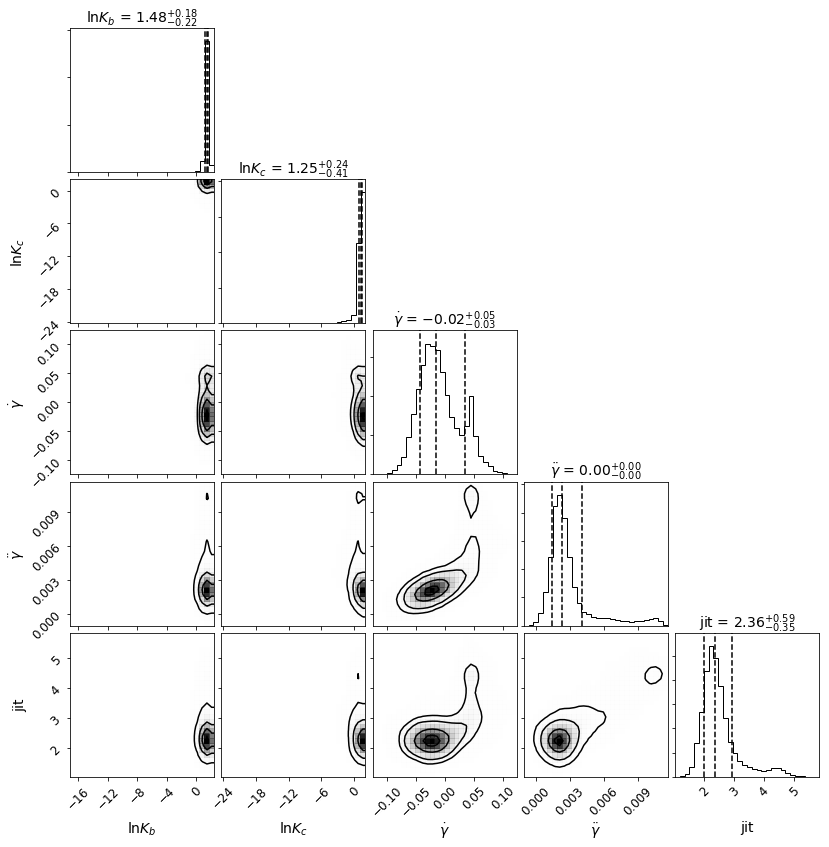

In [11]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

### Eccentric Orbits

Allow ``secosw`` and ``sesinw`` parameters to vary

In [12]:
like.params['secosw1'].vary = True
like.params['sesinw1'].vary = True
like.params['secosw2'].vary = True
like.params['sesinw2'].vary = True

Add an ``EccentricityPrior`` to ensure that eccentricity stays below 1.0. In this example we will also add a Gaussian prior on the jitter (``jit``) parameter with a center at 2.0 m/s and a width of 0.1 m/s.

In [13]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'jit', np.log(2), np.log(0.1))]

Optimize the parameters by maximizing the likelihood and plot the result

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                    0.396056       True
sesinw1                    -0.38132       True
logk1                       1.72061       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                   0.0721476       True
sesinw2                  -0.0243769       True
logk2                        1.5254       True
dvdt                     -0.0306298       True
curv                     0.00179613       True
gamma                       -4.3962      False
jit                         1.98889       True

Priors
------
e1 constrained to be < 0.99
e2 constrained to be < 0.99
Gaussian prior on jit, mu=0.6931471805599453, sigma=-2.3025850929940455



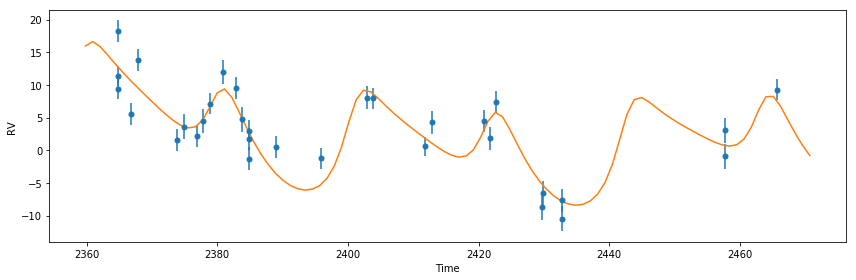

In [14]:
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Nelder-Mead',)

plot_results(like)
print(post)

Plot the final solution

No handles with labels found to put in legend.


(<Figure size 540x786.857 with 5 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fbc40b791d0>])

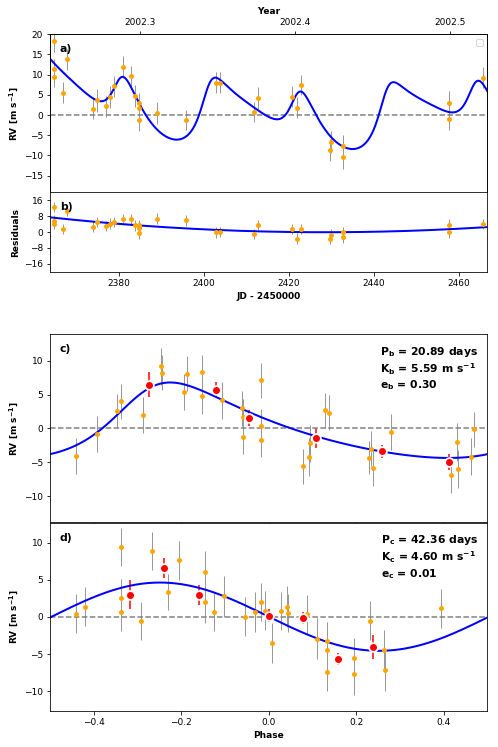

In [15]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()